Funciones de carga y preparación de datos

In [2]:
#!pip install nltk
#!pip install spacy
#!pip install tex

In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm


In [4]:
pwd

'/content'

In [ ]:
# Descarga de archivos de ProfNER
!wget https://zenodo.org/record/4563995/files/profner.zip?download=1
# Si el unzip no funciona, revisar cual es el nombre de descarga del archivo
!unzip  profner.zip?download=1

In [6]:
import sys
import os
import pandas as pd
def get_tweet_content(list_paths):
  """
    Función para guardar en un diccionario el contenido de archivos txt
    que se introduce en su entrada.
    Devuelve un diccionario en el que las claves son el id del tweet, y
    el valor el texto del tweet.
  """
  output_dict = dict()
  for i in list_paths:
    tweet_id = i.split("/")[-1].split(".txt")[0]
    with open(i) as f:
      output_dict[int(tweet_id)] = f.read()

  return output_dict

def get_profner_data(profner_path_data):
    # Obtenemos el path a los txt de los tweets.
    path_to_txt = profner_path_data+"subtask-1/train-valid-txt-files/"
    tweets_train_files = [path_to_txt+"train/"+i for i in os.listdir(path_to_txt+"train/")]
    tweets_valid_files = [path_to_txt+"valid/"+i for i in os.listdir(path_to_txt+"valid/")]
    # Obtenemos diccionarios en los que el key es el tweet_id y el value el texto del tweet.
    train_txt_content = get_tweet_content(tweets_train_files)
    valid_txt_content = get_tweet_content(tweets_valid_files)

    # Cargamos dos dataframes con los tweet_id y la categoría de los tweets
    path_to_labeled = profner_path_data+"subtask-1/"
    train_tweets = pd.read_csv(path_to_labeled+"train.tsv",sep="\t")
    valid_tweets = pd.read_csv(path_to_labeled+"valid.tsv",sep="\t")

    # Introducimos a los df el campo de texto mapeando los diccionarios con tweet_id
    train_tweets["tweet_text"] = train_tweets['tweet_id'].map(train_txt_content)
    train_tweets["set"] = "train"
    valid_tweets["tweet_text"] = valid_tweets['tweet_id'].map(valid_txt_content)
    valid_tweets["set"] = "valid"

    # Concatenamos el resultado
    output_df = pd.concat([train_tweets,valid_tweets],axis=0)
    # Eliminamos retorno de carro
    output_df["tweet_text"] = output_df.tweet_text.apply(lambda x: x.replace('\n', ' '))
    return output_df[["tweet_id","tweet_text","label","set"]].reset_index(drop=True)

# Ejercicio


En este ejercicio se trabajará con un conjunto de datos reales publicados para la shared-task [ProfNER](https://temu.bsc.es/smm4h-spanish/), celebrada en el año 2021. Específicamente, se utilizarán los datos textuales de la subtarea 1, centrada en la clasificación de textos. Este conjunto de datos son tweets en español que tienen asignada una etiqueta numérica, que representa la presencia (valor 1) o no (valor 0) de menciones de profesiones en el tweet. Por si fuera de tu interés, el proceso de obtención, selección y anotación de datos está descrita en [este enlace.](https://temu.bsc.es/smm4h-spanish/?p=4003).

Para el ejercicio debéis entrenar diferentes modelos de clasificación que permitan clasificar correctamente los tweets. Para ello será necesario crear y utilizar funciones de preprocesado de datos similares a las vistas en clase, aplicar estrategias de vectorización de trextos como TF-IDF o embeddings, y entrenar/evaluar modelos de clasificación. Para que os sirva de orientación, los criterios de evaluación del ejercicio serán los siguientes:

-	**Análisis exploratorio, pre-procesado y normalización de los datos (30%)**:
        -	El ejercicio deberá contener un análisis exploratorio de los datos como número de documentos, gráficas de distribución de longitudes y/o wordclouds, entre otros análisis que se os pudieran ocurrir. Vuestros ejercicios deberán incorporar al menos los análisis exploratorios vistos en clase.

    -	También tendréis que tener funciones para normalizar textos que permitan eliminar palabras vacías, quitar símbolos de puntuación y lematizar o hacer stemming.  

-	**Vectorización de textos (40%)**

    En clase hemos visto diferentes estrategias de vectorización como TF-IDF y Word Embeddings. También hemos visto como incorporar características adicionales utilizando el sentimiento de los documentos. Para este ejercicio sois libres de utilizar la estrategia de vectorización que queráis, pero:
  -	Si decidís utilizar TF-IDF será necesarios que incorporéis a modelo características adicionales de sentimiento utilizando recursos adicionales (como por ejemplo la librería TextBlob).
  -	Si optáis por representar el texto mediante embeddings, dado que en clase no se profundizado sobre el tema no será necesario incorporar esas características adicionales. Si decidís esta segunda opción, podéis utilizar los embeddings en español que vimos en clase

-	**Entrenamiento y validación del sistema (30%)**
  -	En el proceso de entrenamiento del modelo tendréis que testear al menos 3 modelos de clasificación. El procedimiento debe ser similar al visto en clase, en el que primero estimábamos el rendimiento de varios algoritmos de forma general, para posteriormente seleccionar el mejor para ajustar los hiperparámetros.


## 0. Imports


In [7]:
import nltk # Paquete para limpiar los datos
import spacy # Usado para la lematización

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

import en_core_web_sm
import es_core_news_sm

spacy.load('es_core_news_sm')
# Se descargan archivos que necesitan las funciones a usar
nltk.download('stopwords') # Tokens que no aportan valor, ralentizando el entrenamiento
nltk.download('punkt') # Requerido para word_tokenize, modelos para tokenizar frases

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer # Tweet

from sklearn.feature_extraction.text import TfidfVectorizer

# Importamos numpy:
import numpy as np

import matplotlib.pyplot as plt # Paquete para gráficos, wrapper de sns
import seaborn as sns           # otro paquete para graficar, complementario a plt
import warnings

from wordcloud import WordCloud
from sklearn.metrics import ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') # Etiquetado
nltk.download('tagsets')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords') # palabras vacias

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `get_profner_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [9]:
profner_path = "./profner/"
datos_ejercicio = get_profner_data(profner_path)

In [10]:
datos_ejercicio.head(5)

,tweet_id,tweet_text,label,set
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0,train


## 2. Análisis exploratorio

In [11]:
datos_ejercicio.tail(5)

,tweet_id,tweet_text,label,set
7995,1263939682662002689,#LoMásLeído | Los nuevos infectados de coronav...,0,valid
7996,1259976635891306516,Ayuso adjudica a dedo un contrato de 30.000 eu...,1,valid
7997,1277128552153055232,Meses encerrados. Se puede viajar a otras prov...,0,valid
7998,1267915731422916613,El gobierno prohíbe por ley lis despidos duran...,0,valid
7999,1273335456529252356,Rasgos psicológicos de por qué no llevas #masc...,0,valid


In [12]:
#print(datos_ejercicio.shape)
print("El corpus del ejercicio planteado contiene un total de {} documentos.".format(datos_ejercicio.shape[0]))
print("El corpus del ejercicio planteado contiene un total de {} columnas.".format(datos_ejercicio.shape[1]))

El corpus del ejercicio planteado contiene un total de 8000 documentos.
El corpus del ejercicio planteado contiene un total de 4 columnas.


In [13]:
sum( datos_ejercicio.duplicated() )

0

In [14]:
datos_ejercicio.groupby(by='label').size()
print('La columna -label- muestra solo valores 0 o 1, por lo cual es un problema de clasificacion binaria.')

La columna -label- muestra solo valores 0 o 1, por lo cual es un problema de clasificacion binaria.


In [15]:
# Test inicial se hizo con la mitad de los datos para acelerar los tiempos de ejecución.
#datos_ejercicio = datos_ejercicio[0:4000]

In [16]:
print(datos_ejercicio.groupby(by='label').size())
print('Vemos que las clases estan desbalanceadas, con una proporcion de 0 aprox. 3 veces mayor a la cantidad de 1.')

label
0    6130
1    1870
dtype: int64
Vemos que las clases estan desbalanceadas, con una proporcion de 0 aprox. 3 veces mayor a la cantidad de 1.


Se muestra graficamente ver cuales son las palabras mas comunes en los diferentes documentos:

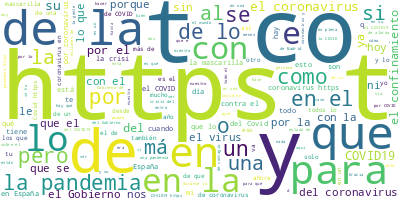

In [69]:
# World Cloud
# Une las frases
long_string = ','.join(list(datos_ejercicio['tweet_text'])) #dataset['normalizacion'].values))
# Genera un objecto WordCloud
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0.5, contour_color='steelblue')
# Genera el wordcloud
wordcloud.generate(long_string)
# Visualizalo en una imagen
wordcloud.to_image()

A simple vista aparecen textos que nos son palabras relevantes, como ser 'https', varias palabras son preposiciones, pronombres o solo una letra ('t'). Estos problemas seran abordados en la parte de preprocesado y normalizacion del texto.

## 3. Preprocesado y Normalización

Funciones para normalizar de los textos:

- Tokenización con NLTK.
- Quitar palabras vacías.
- Quitar símbolos de puntuación.
- Lematización con Spacy.

Se cargan los paquetes y se definen funciones a usar, con comentarios extra respecto a los notebooks del profesor.

In [17]:

# Tokenizar el texto.
def tokenize(texto):# De string (texto) a lista de substrings (tokens)
  tweet_tokenizer = TweetTokenizer()
  #tokens_list = word_tokenize(texto, language='spanish')    # Corpus estaba en español.
  tokens_list = tweet_tokenizer.tokenize(texto)
  return tokens_list


# Quitar stopwords de una lista de tokens
def quitar_stopwords(tokens):
    stop_words = stopwords.words('spanish') # quitamos el set
    filtered_sentence = [w for w in tokens if not w in stop_words]# quedarse con tokes no stopwords
    return filtered_sentence

# Quitar símbolos de puntuación, no aporta significado
def quitar_puntuacion(tokens):
    words=[word for word in tokens if word.isalnum()] # quedarse con los tokens alfa-numericos
    return words


# Lematizacion.
nlp = es_core_news_sm.load(disable=['parser', 'ner'])

def lematizar(tokens):
    sentence = " ".join(tokens) # unir los tokens, separándolos por espacio
    mytokens = nlp(sentence)# transformarlo con el pipeline

    # Lematizamos los tokens y los convertimos  a minusculas.
    mytokens2 = [ word.lemma_ for word in mytokens ] #if word.lemma_ != "-PRON-" ]
    mytokens3 = [ word.lower() for word in mytokens2 ]

    # Extraemos el text en una string
    return " ".join(mytokens3)

In [18]:
def limpieza_tokens(df, apply_tokenize = True, apply_puntuacion = True, apply_stopwords = True, apply_lematizar = True) :
    # Se deja la posibilidad de no aplicar todas las funciones anteriores.
    # Por defecto, se aplicarán. Esta decisión de diseño tiene como ventaja
    # la versatilidad y como desventaja posibles errores de consistencia como
    # no haber definido la columna 'normalizacion'

    if apply_tokenize:
      df['normalizacion'] = df['tweet_text'].apply(lambda x: tokenize(x))

    if apply_puntuacion:
       df['normalizacion'] = df['normalizacion'].apply(lambda x: quitar_puntuacion(x))

    if apply_stopwords:
       df['normalizacion'] = df['normalizacion'].apply(lambda x: quitar_stopwords(x))

    if apply_lematizar:
       df['normalizacion'] = df['normalizacion'].apply(lambda x: lematizar(x))

    return df


dataset = limpieza_tokens(datos_ejercicio)  # Aplicamos todas las transformaciones

In [19]:
dataset.head(5)

,tweet_id,tweet_text,label,set,normalizacion
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train,china libero pandemia libero ovnis argentina l...
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train,san francisco eeuu hacer 100 año tras vivir pa...
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train,porfi poneo mascarilla 28 nuevo canción artist...
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train,el nuevo covid norma regla recibimiento comerc...
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0,train,si confinamiento dejado tocado estabilidad men...


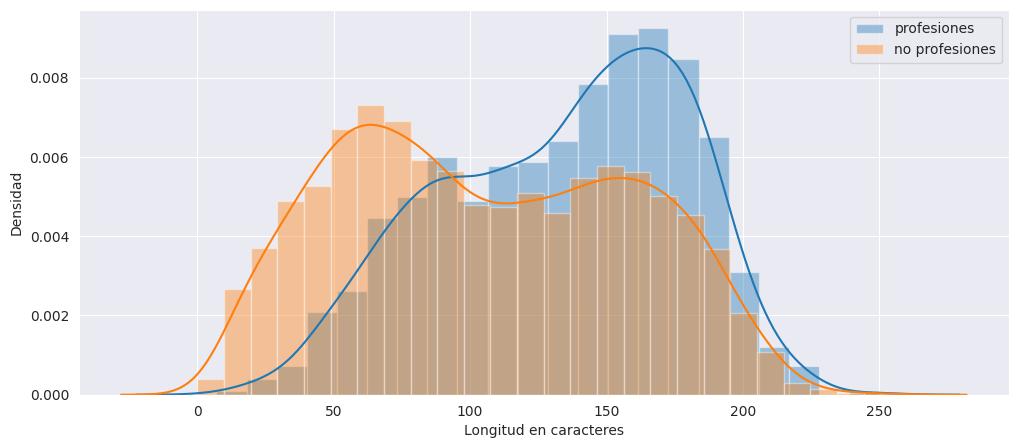

In [20]:
warnings.filterwarnings('ignore')

dataset.char_len = dataset.normalizacion.apply(lambda x: len(x))

fig = plt.figure(figsize=(12,5))
sns.set_style("darkgrid")
ax1 = sns.distplot(dataset.char_len[dataset.label == 1], hist=True, label="profesiones")     # distribución char_len
ax2 = sns.distplot(dataset.char_len[dataset.label == 0], hist=True, label="no profesiones"). # distribución char_len
plt.legend()
plt.xlabel('Longitud en caracteres')
plt.ylabel('Densidad')
plt.show()

Tras la limpieza de los documentos del corpus, se procede a calcular y representar gráficamente las longitudes en tokens de estos.

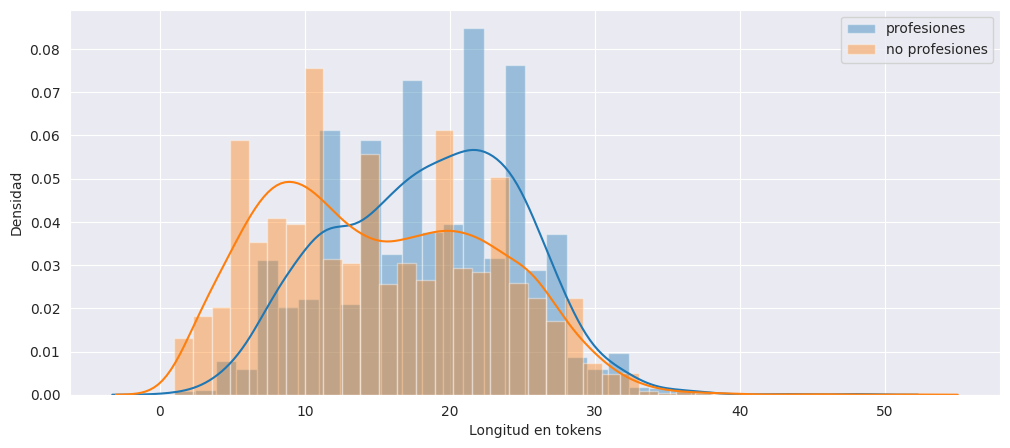

In [21]:
fig = plt.figure(figsize=(12,5))
sns.set_style("darkgrid")

dataset.number_tokens = dataset.normalizacion.apply(lambda x: len(x.split(' ')))

ax3 = sns.distplot(dataset.number_tokens[dataset.label == 1], hist=True, label="profesiones")
ax4 = sns.distplot(dataset.number_tokens[dataset.label == 0], hist=True, label="no mencion de profesiones")
plt.legend()
plt.xlabel('Longitud en tokens')
plt.ylabel('Densidad')
plt.show()

Se observa que la longitud en tokens disminuye respecto a la longitud en caracteres. Las distribuciones para las dos clases son muy similares en ambas representaciones. Por tanto, estas dos longitudes no son una forma muy efectiva de diferenciar las clases de la variable objetivo.

Se calculan y representan gráficamente en forma de histograma los 12 tokens más utilizados en cada una de las clases del corpus, después del proceso de limpieza.

Para esto se crea la función tokens_comunes

In [23]:
def tokens_comunes(df, label):

  df = df.normalizacion[df.label == label]        # Nos centramos solo en la clase dada por label
  tokens = []                                     # Extraemos todos los tokens y los guardamos en esta lista
  df.apply(lambda x: tokens.append(x.split(' '))) # añadimos los tokens a la lista, cuyos elementos será a su vez listas
  tokens = pd.Series( [item for sublist in tokens for item in sublist] ) # pasamos de lista de lista -> lista -> serie
  tokens = tokens.value_counts()[:12].            # Mostrar solo los 12 más frecuentes de la serie
  return tokens

tokens_1 = tokens_comunes(dataset, 1)
tokens_0 = tokens_comunes(dataset, 0)

Text(0.5, 1.0, 'Frecuencia tokens más comunes con label = 1')

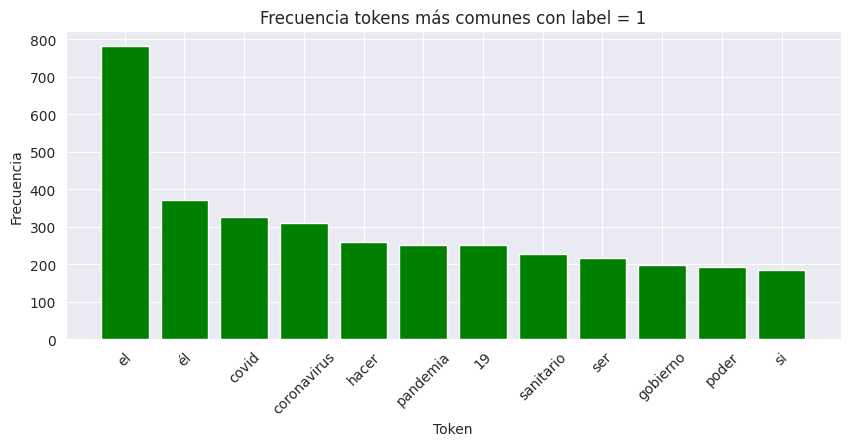

In [24]:
fig = plt.figure(figsize=(10,4))

plt.bar( tokens_1.index, tokens_1, color = 'g')# color verde para label  = 1
plt.xticks(rotation=45)
# Títulos
plt.xlabel('Token')
plt.ylabel('Frecuencia')
plt.title('Frecuencia tokens más comunes con label = 1')


Text(0.5, 1.0, 'Frecuencia tokens más comunes con label = 0')

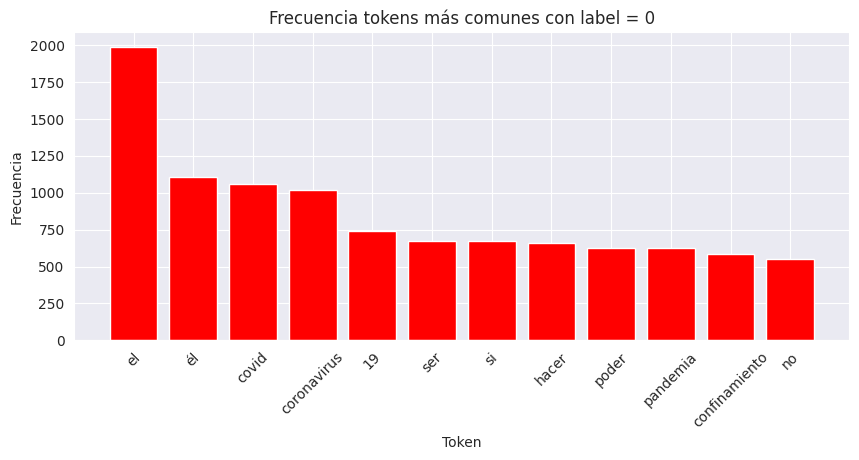

In [25]:
fig = plt.figure(figsize=(10,4))
plt.bar( tokens_0.index, tokens_0, color = 'r') # Color rojo para label  = 0
plt.xticks(rotation=45)
# Ponemos nombres a los ejes y añadimos un título
plt.xlabel('Token')
plt.ylabel('Frecuencia')
plt.title('Frecuencia tokens más comunes con label = 0')

Se observa que el token mas comun es de hecho el termino '19', el cual no es una palabra relevante para el contexto de este problema, ya que solo indica que la palabra 'covid19' fue separada en 'covid' y '19'. Tambien otros elementos comunes son las palabra 'el' y 'él', ya que estos son pronombres podemos prescindir de ellos. Por lo cual podemos borrar dichos tokes, y evitar que produzcan un sesgo en los datos.

In [26]:
dataset['normalizacion'][5]
dataset['normalizacion'][3]

'el nuevo covid norma regla recibimiento comercio minorista español pateando día mas calle tienda madrid conocer mostrar nuevo consumo normalidad'

In [27]:
strings = ['el ','él ','19 ']
# Aqui mantengo el espacio al final de 'el' asi me aseguro que estoy eliminando las apariciones
# de el como articulo o pronombre, y no cualquier 'el' que pertenezca a alguna otra palabra, como por ejemplo 'elemento'.

for s in strings:
  dataset['normalizacion'] = dataset['normalizacion'].apply(lambda x: x.replace(s,'') if (s in x) else x)

dataset.head(2)

,tweet_id,tweet_text,label,set,normalizacion
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train,china libero pandemia libero ovnis argentina l...
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train,san francisco eeuu hacer 100 año tras vivir pa...


In [28]:
dataset['normalizacion'][5]
dataset['normalizacion'][3]

'nuevo covid norma regla recibimiento comercio minorista español pateando día mas calle tienda madrid conocer mostrar nuevo consumo normalidad'

Text(0.5, 1.0, 'Frecuencia tokens más comunes con label = 1')

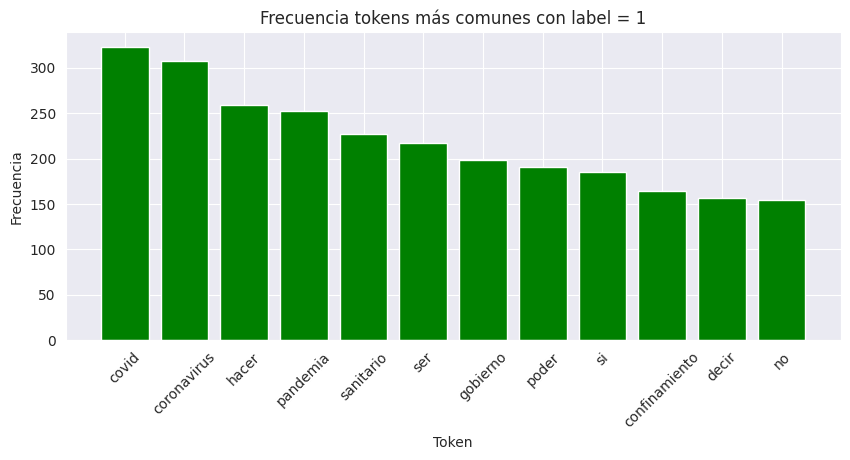

In [29]:
tokens_1 = tokens_comunes(dataset, 1)
tokens_0 = tokens_comunes(dataset, 0)

fig = plt.figure(figsize=(10,4))
plt.bar( tokens_1.index, tokens_1, color = 'g')# color verde para label  = 1
plt.xticks(rotation=45)
# Ponemos nombres a los ejes y añadimos un título
plt.xlabel('Token')
plt.ylabel('Frecuencia')
plt.title('Frecuencia tokens más comunes con label = 1')

Text(0.5, 1.0, 'Frecuencia tokens más comunes con label = 0')

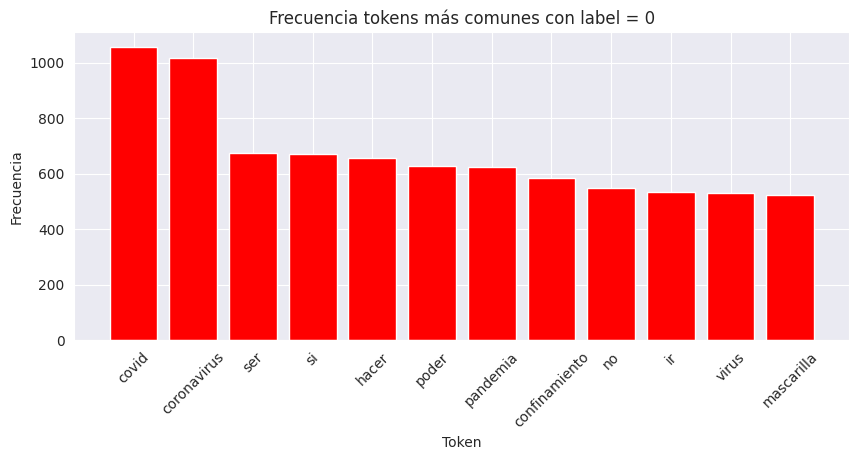

In [30]:
fig = plt.figure(figsize=(10,4))
plt.bar( tokens_0.index, tokens_0, color = 'r') # Color rojo para label 0
plt.xticks(rotation=45)
# Ponemos nombres a los ejes y añadimos un título
plt.xlabel('Token')
plt.ylabel('Frecuencia')
plt.title('Frecuencia tokens más comunes con label = 0')

Se muestra nuevamente el grafico de Word Cloud, para observar como han cambiado las palabras mas comunes en el texto ya normalizado.

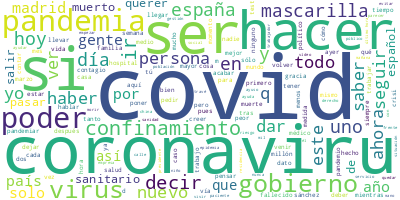

In [31]:

# Une las frases
long_string = ','.join(list(dataset['normalizacion'].values))
# Genera un objecto WordCloud
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0.5, contour_color='steelblue')
# Genera el wordcloud
wordcloud.generate(long_string)
# Visualizalo en una imagen
wordcloud.to_image()

Haciendo los graficos de las palabras mas comunes nuevamente y el word cloud, podemos ver que palabras irrelevantes como 'el' y '19' han desaparecido. Se observan palabras como covid, pandemia, gobierno, que pueden ser mas relevantes en termino de la relacion con mencionar profesiones  o no en el Tweet.

## 4. Vectorización

Usando la función 'TfidfVectorizer' con los siguientes aspectos:

- Pocas características (100 en total) para evitar overfitting
- Considerar unigramas, bigramas y trigramas
- Que el sistema no considere los elementos que salgan en menos del 4% de los documentos.

In [32]:

vectorizador = TfidfVectorizer(ngram_range = (1, 3), min_df = 0.04, max_features= 100,  lowercase = True) #norm=None, smooth_idf=False) #
#tfidf_data = vectorizador.fit(dataset.normalizacion)
tfidf_data = vectorizador.fit(dataset.normalizacion)
tfidf_data_result = vectorizador.fit_transform(dataset.normalizacion).toarray()
# ajustamos y transformamos, en sucesivas evaluaciones del
# modelo con otros corpora solo abra que transformarlas con vectorizador.

In [33]:
tfidf_data

TfidfVectorizer(max_features=100, min_df=0.04, ngram_range=(1, 3))

In [34]:
print("\n\n TF-IDF VECTORIZER")
print("Obtenemos un dictionario que mapea las palabras con su posición en el vector del vocabulario")
print(tfidf_data.vocabulary_)
print("Obtenemos el vocabulario en si mismo como una lista")
print(tfidf_data.get_feature_names_out())
print("Numero de características:")
print(len(tfidf_data.get_feature_names_out()))



 TF-IDF VECTORIZER
Obtenemos un dictionario que mapea las palabras con su posición en el vector del vocabulario
{'pandemia': 17, 'hacer': 11, 'mascarilla': 14, 'nuevo': 16, 'covid': 2, 'día': 6, 'si': 23, 'confinamiento': 0, 'poder': 19, 'españa': 8, 'ver': 26, 'no': 15, 'decir': 5, 'coronavirus': 1, 'ser': 22, 'sanitario': 20, 'crisis': 3, 'seguir': 21, 'uno': 25, 'persona': 18, 'gobierno': 9, 'en': 7, 'dar': 4, 'yo': 28, 'haber': 10, 'ir': 13, 'virus': 27, 'hoy': 12, 'todo': 24}
Obtenemos el vocabulario en si mismo como una lista
['confinamiento' 'coronavirus' 'covid' 'crisis' 'dar' 'decir' 'día' 'en'
 'españa' 'gobierno' 'haber' 'hacer' 'hoy' 'ir' 'mascarilla' 'no' 'nuevo'
 'pandemia' 'persona' 'poder' 'sanitario' 'seguir' 'ser' 'si' 'todo' 'uno'
 'ver' 'virus' 'yo']
Numero de características:
29


Se han encontrado 29 características relevantes.

In [35]:
tfidf_data_result

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.42999944, 0.        ,
        0.        ],
       [0.        , 0.46260928, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Heat Map de todos los documentos.

<Axes: >

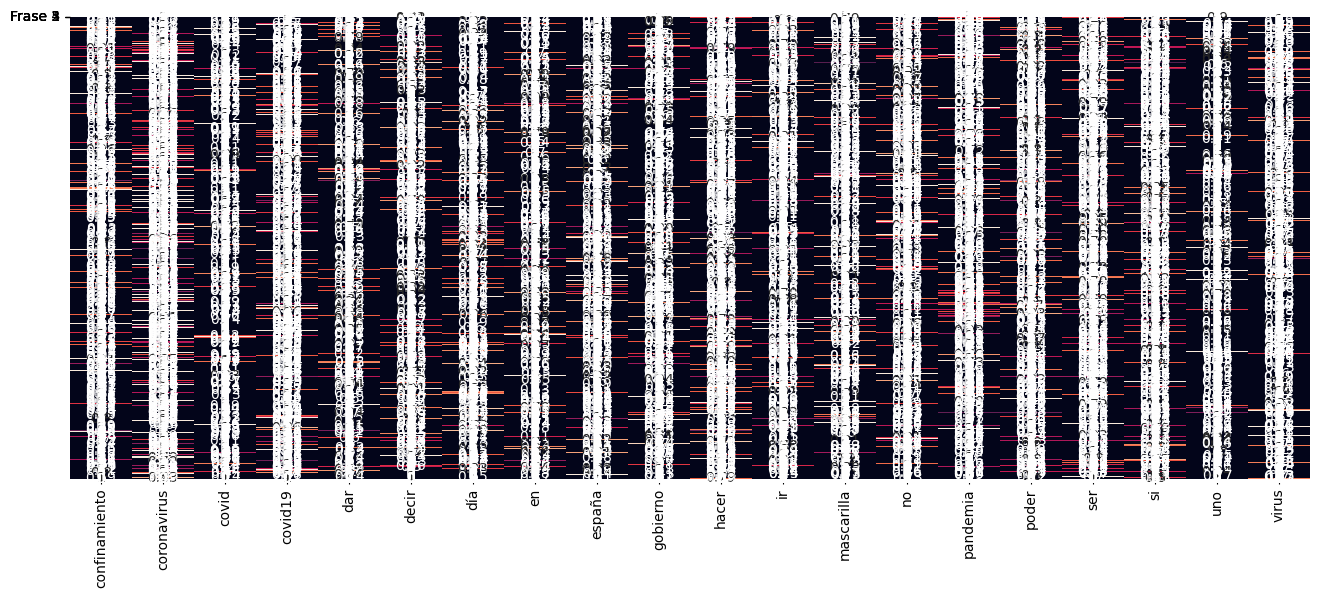

In [81]:

plt.figure(figsize=(16, 6))
# Figura CountVectorizer
sns.heatmap(tfidf_data_result, annot=True,cbar=False,
            xticklabels=tfidf_data.get_feature_names_out(),
            yticklabels = ["Frase 1", "Frase 2", "Frase 3","Frase 4", "Frase 5"])

Es dificil visualizar los valores cuando usamos todos los documentos, por lo que se muestra un subset de solo 20 lineas a continuacion:

<Axes: >

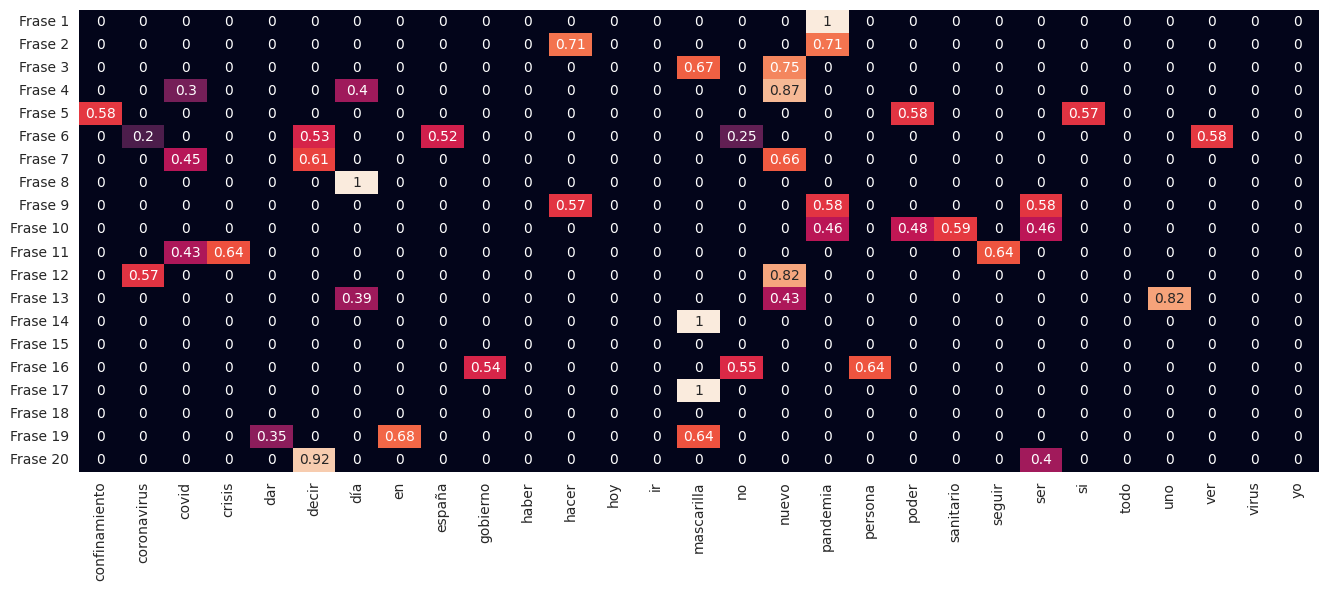

In [36]:
plt.figure(figsize=(16, 6))
#Figura CountVectorizer
sns.heatmap(tfidf_data_result[0:20], annot=True, cbar=False,
            xticklabels=tfidf_data.get_feature_names_out(),
            yticklabels = ["Frase 1", "Frase 2", "Frase 3","Frase 4", "Frase 5","Frase 6", "Frase 7", "Frase 8","Frase 9", "Frase 10", "Frase 11", "Frase 12", "Frase 13","Frase 14", "Frase 15","Frase 16", "Frase 17", "Frase 18","Frase 19", "Frase 20"])

In [37]:
dataset

,tweet_id,tweet_text,label,set,normalizacion
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train,china libero pandemia libero ovnis argentina l...
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train,san francisco eeuu hacer 100 año tras vivir pa...
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train,porfi poneo mascarilla 28 nuevo canción artist...
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train,nuevo covid norma regla recibimiento comercio ...
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0,train,si confinamiento dejado tocado estabilidad men...
...,...,...,...,...,...
7995,1263939682662002689,#LoMásLeído | Los nuevos infectados de coronav...,0,valid,nuevo infectado coronavirus multiplicar casi 2...
7996,1259976635891306516,Ayuso adjudica a dedo un contrato de 30.000 eu...,1,valid,ayuso adjudico dedo contrato euros hacer vídeo...
7997,1277128552153055232,Meses encerrados. Se puede viajar a otras prov...,0,valid,mes encerrado poder viajar provincia ir restau...
7998,1267915731422916613,El gobierno prohíbe por ley lis despidos duran...,0,valid,gobierno prohíbir ley lis despido crisis coron...


## 5. Entrenamiento y evaluación de modelos


Entramos ya en el apartado de entrenamiento del modelo. El primer paso es definir las variables predictoras, que son las características extraidas anteriormente a través de TF-IDF.

También especificaremos cual es la variable con las clases de cada documento.

In [38]:
# Definimos la variable de categorías:
y = dataset["label"].values.astype(np.float32)

print(y.shape)

(8000,)


In [39]:
vector_data = vectorizador.fit_transform(dataset.normalizacion)
vector_data

<8000x29 sparse matrix of type '<class 'numpy.float64'>'
	with 16863 stored elements in Compressed Sparse Row format>

En primer lugar, dividamos el dataset en Train/Test:

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vector_data, y , random_state=0)
print(X_train.shape)
print(X_test.shape)

(6000, 29)
(2000, 29)


**Decision de modelo de ML a utilizar**

En primer lugar se ha generado una función para medir la calidad de varios modelos estándar de forma fácil y ver sus resultados.

La función hace un KFold y evalua diferentes modelos con una métrica de evaluación:

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, GridSearchCV,   RandomizedSearchCV

# Cargamos los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore") # evitar que se muestren los warnings en la pantalla

seed = 1

# Paramentros de los diferentes modelos
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']# Parámetro de regularización
c_values = [100, 10, 1.0, 0.1, 0.01]# Parámetro de regularización
grid_lr = dict(solver=solvers,penalty=penalty,C=c_values)

criterios             = ['gini','entropy']
min_samples_leaf_vec  = [1, 10, 20]# mínimo tamaño de las hojas
grid_dtc = dict( criterion = criterios, min_samples_leaf = min_samples_leaf_vec )


n_estimators_vec     = [50, 100, 200, 500 ] # número de árboles
min_samples_leaf_vec = [1,    10,  20 ]# mínimo tamaño de las hojas
max_samples_vec      = [0.6, 0.8,   1 ]# tamaño submuestra
grid_rfc             = dict(n_estimators=n_estimators_vec, min_samples_leaf=min_samples_leaf_vec, max_samples=max_samples_vec)


models = []
models.append(['LR', LogisticRegression(random_state=seed), grid_lr])
models.append(['DTC', DecisionTreeClassifier(random_state=seed), grid_dtc]) #['GaussianNB', GaussianNB(), grid_gnb ])
models.append(['RFC', RandomForestClassifier(random_state=seed), grid_rfc])

grid_results = []

for name, model,grid in models:
    # shuffle al comienzo para reducir riesgo de sobreajuste
    cv_technique = KFold(n_splits=5, shuffle = True, random_state = seed )
    #njobs = -1. Usar todos los procesadores

    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv_technique, scoring='accuracy',error_score='raise')
    grid_results.append( grid_search.fit(X_train, y_train) )


In [62]:
print("Mejor accuracy: %f usando los parámetros %s" % (grid_results[0].best_score_, grid_results[0].best_params_))
print("Mejor accuracy: %f usando los parámetros %s" % (grid_results[1].best_score_, grid_results[1].best_params_))
print("Mejor accuracy: %f usando los parámetros %s" % (grid_results[2].best_score_, grid_results[2].best_params_))

Mejor accuracy: 0.771833 usando los parámetros {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Mejor accuracy: 0.766167 usando los parámetros {'criterion': 'entropy', 'min_samples_leaf': 20}
Mejor accuracy: 0.774333 usando los parámetros {'max_samples': 0.6, 'min_samples_leaf': 10, 'n_estimators': 50}


### Mejor Modelo
El modelo con mejor score es el RandomForestClassifier seguido por LogisticRegression.
A continuacion se entrena el modelo usando X_train, y predicen los resultados usando el set X_test.

In [63]:

model = RandomForestClassifier(max_samples= 0.6, min_samples_leaf= 10, n_estimators= 50)  # Random Forest
model.fit(X_train,y_train)

RandomForestClassifier(max_samples=0.6, min_samples_leaf=10, n_estimators=50)

In [65]:
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1523   20]
 [ 401   56]]
              precision    recall  f1-score   support

         0.0       0.79      0.99      0.88      1543
         1.0       0.74      0.12      0.21       457

    accuracy                           0.79      2000
   macro avg       0.76      0.55      0.54      2000
weighted avg       0.78      0.79      0.73      2000



In [67]:
pd.DataFrame(grid_results[2].cv_results_)[['rank_test_score', 'mean_test_score','std_test_score']]# Random Forest

,rank_test_score,mean_test_score,std_test_score
0,33,0.754167,0.009204
1,29,0.757833,0.009798
2,31,0.755833,0.009006
3,30,0.757333,0.010102
4,1,0.774333,0.007645
5,6,0.773500,0.008746
6,11,0.773167,0.008290
7,6,0.773500,0.008618
8,9,0.773167,0.008537
9,14,0.772833,0.009015


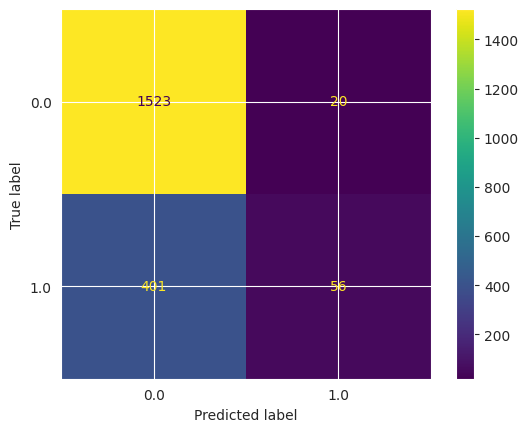

In [66]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize = None)

### 2do Mejor modelo
Se exploran los resultados del segundo mejor modelo: LogisticRegression

In [52]:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model=LogisticRegression(C=100, penalty="l2", solver = "newton-cg")
model.fit(X_train,y_train)


LogisticRegression(C=100, solver='newton-cg')

Predecimos con el set de test, y creamos una matriz de confusión y un "classification report".

In [53]:
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1518   25]
 [ 407   50]]
              precision    recall  f1-score   support

         0.0       0.79      0.98      0.88      1543
         1.0       0.67      0.11      0.19       457

    accuracy                           0.78      2000
   macro avg       0.73      0.55      0.53      2000
weighted avg       0.76      0.78      0.72      2000



In [57]:
pd.DataFrame(grid_results[0].cv_results_)[['rank_test_score', 'mean_test_score','std_test_score']]# Regresión Logística

,rank_test_score,mean_test_score,std_test_score
0,1,0.771833,0.008715
1,1,0.771833,0.008715
2,1,0.771833,0.008904
3,1,0.771833,0.008904
4,5,0.771667,0.008724
5,5,0.771667,0.008724
6,8,0.769500,0.007846
7,7,0.769833,0.008086
8,9,0.764500,0.007390
9,9,0.764500,0.007390


Matriz de confusión.

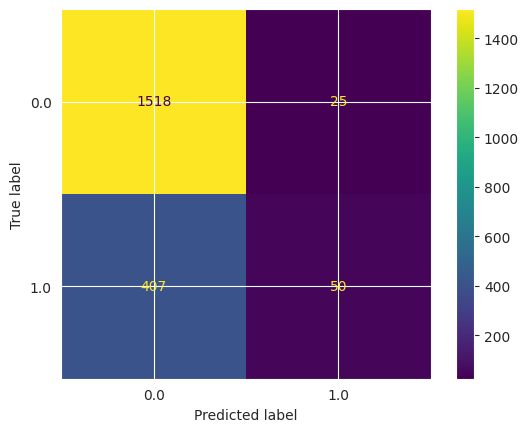

In [54]:

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize = None)

<Figure size 800x400 with 0 Axes>

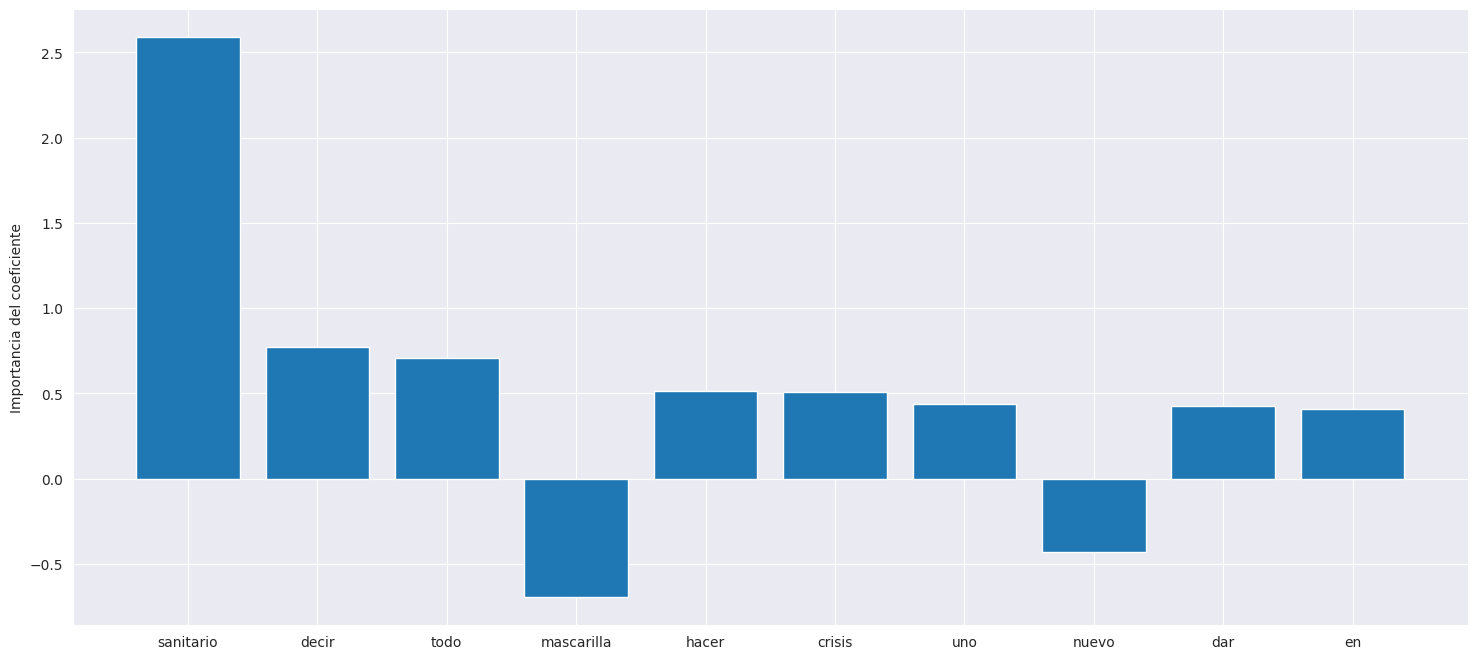

In [55]:
# Obtener la importancia de las variables del modelo
model = LogisticRegression(C=100, penalty="l2", solver = "newton-cg")   # Regresión Logística
model.fit(X_train,y_train)

importance = model.coef_[0]

X_columns = tfidf_data.get_feature_names_out().tolist()

importance_df = []# futuro dataframe con las variables ordenadas por importancia

fig = plt.figure(figsize=(8,4))
# Mostrar el número de la característica, con su nombre, y su score de importancia

for i,v in enumerate(importance):
    importance_df.append([X_columns[i],v])

importance_df = pd.DataFrame(importance_df)

importance_df.columns = ['Variable', 'Importancia']

importance_df = importance_df.sort_values(by='Importancia', key=abs, ascending = False).iloc[:10,:]# ordenamos y filtramos

importance_df
# plot feature importance
fig = plt.figure(figsize=(18,8))
plt.bar(importance_df.Variable, importance_df.Importancia)
plt.ylabel('Importancia del coeficiente')
plt.show()